## The Third Generation Kalman Filter
##### Identical to the initial Kalman Filter, used on the raw dataset taken from the Sentinel satellites. 

##### Of interest is how this same filter maintains its confidence throughout the dataset, whereas it quickly lost confidence on the cleaned data.



### Phase 1) Data Preparation


In [ ]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load Appropriate Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import math, time
from sklearn.metrics import mean_squared_error
import plotly.express as px
import plotly.graph_objects as go

In [ ]:
# Copy relevant data over (here, we'll be using the raw dataset).
!cp /content/drive/MyDrive/Kalman_Filter/combined_sentinel_raw.csv /content/ # Note! This is the raw dataset, not the 2 std dev dataset.

In [ ]:
# Step 0 is always loading and isolating the relevant data.
df = pd.read_csv("combined_sentinel_raw.csv")


In [ ]:
df = df.drop(columns=['Unnamed: 0'], axis=1)
df.head(2)

,date,lake,latitude,longitude,orbit,water_level
0,20160403,Athabasca,59.244637,-108.047469,303,208.303892
1,20160403,Athabasca,59.247528,-108.049405,303,208.131251


In [ ]:
# Isolate the readings from Lake Winnipeg
win = df[df['lake'] == 'Winnipeg']
win.head(2)

,date,lake,latitude,longitude,orbit,water_level
422462,20160401,Winnipeg,51.860057,-96.819518,283,217.4011
422463,20160401,Winnipeg,51.857120,-96.820913,283,217.5197


##### Step 1, finding the average error per timestep.

In [ ]:
 # This is the first change from the original Kalman Filter. Minimum and maximum error will also be calculated. 

# As each recording of water level on a lake shouldn't vary in the time it takes
#. for a single track, any recorded variance would be part of the error. 

win_error = [] # Create a list where each track's error can be collected. 
  
for i in win.date.unique(): # Collect the error of each track. 
  min = win[win['date'] == i].water_level.min()
  max = win[win['date'] == i].water_level.max() 
  error = max - min
  win_error.append(error)

avg_error = np.mean(win_error)
max_error = np.max(win_error) 
min_error = np.min(win_error) 
uncertainty = avg_error*avg_error # This is the old equation for uncertainty. Observe how enormous this number is. 
print("The average error (in meters) is:", avg_error)
print("The maximum error is", max_error)
print("The minimum error is", min_error)

The average error (in meters) is: 8.41012065934066
The maximum error is 65.76687520000002
The minimum error is 0.3317239999999799


In [ ]:
"""std = win.water_level.std()
for i in win.date.unique(): # Collect the error of each track. 
  mean = win[(win.date == i)].water_level.mean()
  low = mean - 3 * std
  high = mean + 3 * std
  for w in win([win.date == i)].water_level:
    if w > high or w < low:
"""


'std = win.water_level.std()\nfor i in win.date.unique(): # Collect the error of each track. \n  mean = win[(win.date == i)].water_level.mean()\n  low = mean - 3 * std\n  high = mean + 3 * std\n  for w in win([win.date == i)].water_level:\n    if w > high or w < low:\n'

##### Step 2, finding the average water level per timestep. 
##### (Addendum: finding the upper and lower quantiles per timestep)
##### (Addendum 2: finding the minima and maxima of each timestep) 

In [ ]:
water_mean = [] # Create a repository for average water levels per track. 
lower_quant = [] # Create a repository for lower quantile water levels per track. 
upper_quant = [] # Create a repository for upper quantile water levels per track. 
minimum = [] # Create a repository for minimumwater levels per track.
maximum = [] # Create a repository for maximum water levels per track.

for i in win.date.unique(): # Collect the mean/lower/upper quantiles/minimum/maximum of each track. 
  mean = win[win['date'] == i].water_level.mean()
  water_mean.append(mean)
  lower = win[win['date'] == i].water_level.quantile(.25)
  lower_quant.append(lower)
  upper = win[win['date'] == i].water_level.quantile(.75)
  upper_quant.append(upper)
  min = win[win['date'] == i].water_level.min()
  minimum.append(min)
  max = win[win['date'] == i].water_level.max()
  maximum.append(max)

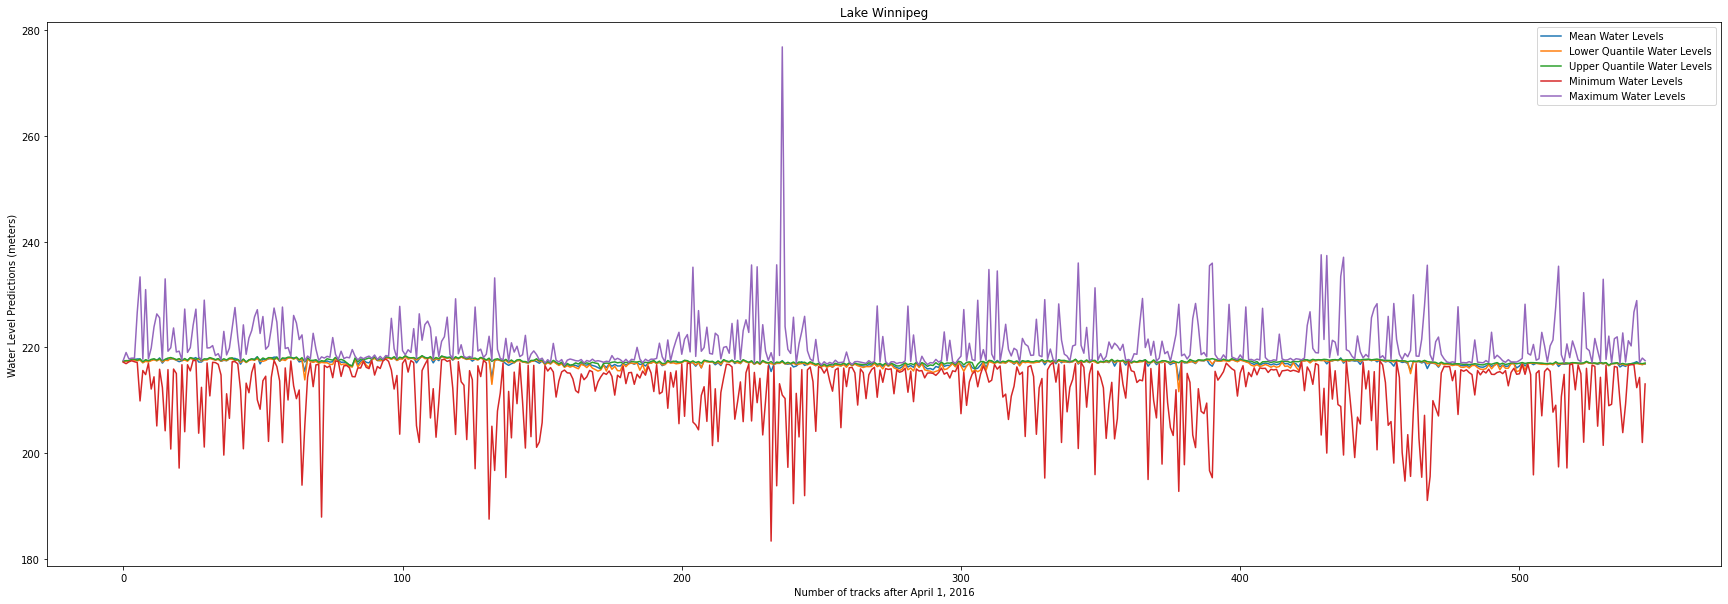

In [ ]:
# Water level mean, quantiles, minima and maxima; graphed.  
x = range(len(water_mean))

y = water_mean
y2 = lower_quant
y3 = upper_quant
y4 = minimum
y5 = maximum

f = plt.figure()
f.set_figwidth(30)
f.set_figheight(10)
plt.title("Lake Winnipeg")
plt.xlabel("Number of tracks after April 1, 2016") # A track varies in timing, but averages to every 3 days.
plt.ylabel("Water Level Predictions (meters)")
plt.plot(y, label = 'Mean Water Levels')
plt.plot(y2, label = 'Lower Quantile Water Levels')
plt.plot(y3, label = 'Upper Quantile Water Levels')
plt.plot(y4, label = 'Minimum Water Levels')
plt.plot(y5, label = 'Maximum Water Levels')


plt.legend()
plt.show()

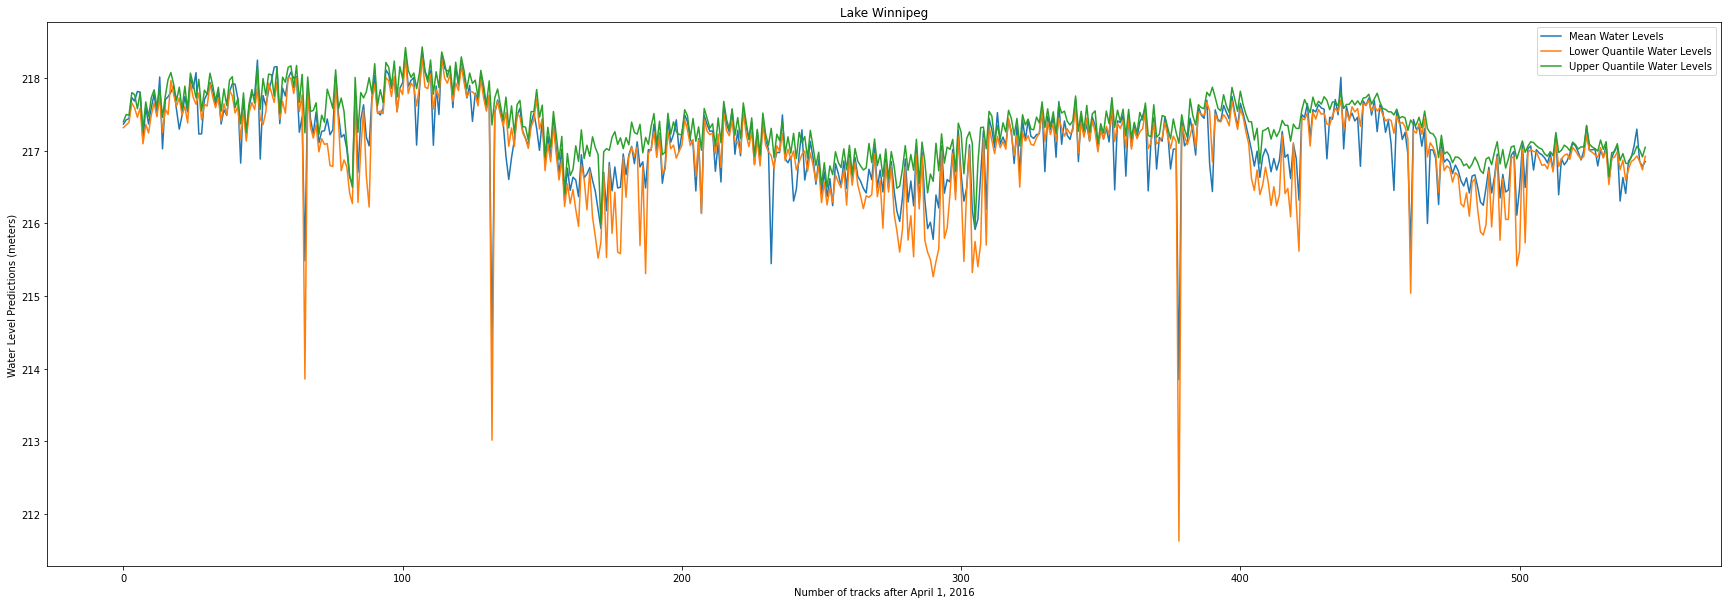

In [ ]:
# The same graph, with minima and maxima removed. 
x = range(len(water_mean))

y = water_mean
y2 = lower_quant
y3 = upper_quant
y4 = minimum
y5 = maximum

f = plt.figure()
f.set_figwidth(30)
f.set_figheight(10)
plt.title("Lake Winnipeg")
plt.xlabel("Number of tracks after April 1, 2016") # A track varies in timing, but averages to every 3 days.
plt.ylabel("Water Level Predictions (meters)")
plt.plot(y, label = 'Mean Water Levels')
plt.plot(y2, label = 'Lower Quantile Water Levels')
plt.plot(y3, label = 'Upper Quantile Water Levels')
#plt.plot(y4, label = 'Minimum Water Levels')
#plt.plot(y5, label = 'Maximum Water Levels')


plt.legend()
plt.show()

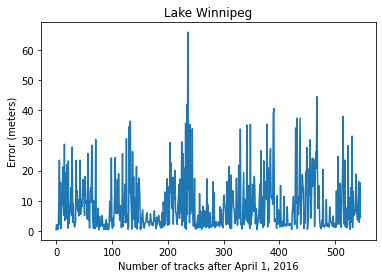

In [ ]:
# A visual representation of the errors per time step. 
x = range(546)
y = win_error
plt.title("Lake Winnipeg")
plt.xlabel("Number of tracks after April 1, 2016") # A track varies in timing, but averages to every 3 days.
plt.ylabel("Error (meters)")
plt.plot(x,y)
plt.show()

### Phase Two) Building the Kalman Filter

In [ ]:
# Step 1) Initial inputs
x = 'predicted water level of a given time step'
p = 'recorded error of a given time step'
o = 'old'
n = 'new'
# The initial water level will be the mean of all the water level means. 
x_o = np.mean(water_mean)
print("The initial recorded water level is:", x_o)
# The initial predicted error will be the mean of the errors
p_o = np.mean(win_error)
print("The initial predicted error is:", p_o)
# Process Noise
# (This is a factor that is considered unmeasurable, but it evident in all the readings. As the ESA stated the Sentinel Satellite 'error' is 10-15cm, likely meaning unmeasurable error)
q = ((15+10)/2)/100
print("The Process noise 'Q', in meters, is:", q)
print("...")
p_n = p_o + q
print("The updated initial predicted error is:", p_n)
x_n = x_o + q
print("The updated initial predicted water level is", x_n)

The initial recorded water level is: 217.12653212742828
The initial predicted error is: 8.41012065934066
The Process noise 'Q', in meters, is: 0.125
...
The updated initial predicted error is: 8.53512065934066
The updated initial predicted water level is 217.25153212742828


In [ ]:
# Step 2) Iterating through time steps

kalman_gains = [] # --> To record the Kalman Gains per iteration.
water_est = [] # --> To record the predicted water levels. 
predicted_errors = [] # --> To record the estimated errors. 

z = 'measured water level'
err = 'coeficient of error' # This used to be the error of a given time step, squared. With errors of 70 meters, this is not functional. 
k = 'Kalman gain'

for i in range(len(water_mean)):
   z = water_mean[i]
   norm_err = ((water_mean[i] - minimum[i])/((maximum[i]-minimum[i])/2)) # This will reduce the impact of such massively varying error. 
   err = norm_err * norm_err
   err = win_error[i] * win_error[i]
   x_o = x_n
   k = p_n/(p_o + err)
   kalman_gains.append(k)
   # Estimating the current state: x 1,1 = x 1,0 + K1(z1 - x 1,0) 
   x_n = x_o + k * (z-x_o) 
   water_est.append(x_n)
   # Update the current estimate uncertainty: 
   p_n = (1-k)*(p_o) 
   predicted_errors.append(p_n)
   x_o = x_n
   # Prediction
   # (predicted water level): 
   x_n = x_o
   # (extrapolated estimate uncertainty): 
   p_n = p_o + q
   p_o = p_n


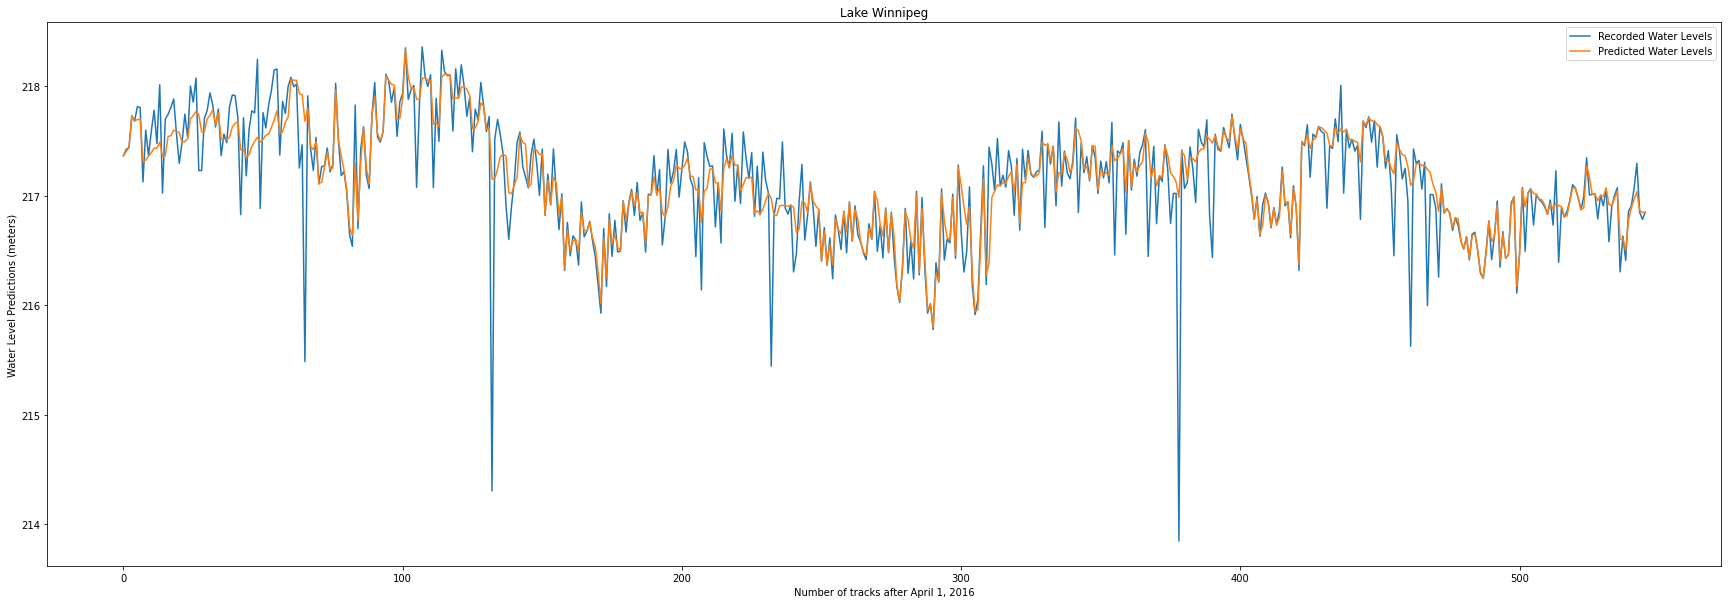

In [ ]:
# Now to plot the estimated water levels against the recorded measurements. 
x = range(len(water_mean))
y2 = water_est
y = water_mean

f = plt.figure()
f.set_figwidth(30)
f.set_figheight(10)
plt.title("Lake Winnipeg")
plt.xlabel("Number of tracks after April 1, 2016") # A track varies in timing, but averages to every 3 days.
plt.ylabel("Water Level Predictions (meters)")
plt.plot(y, label = 'Recorded Water Levels')
plt.plot(y2, label = 'Predicted Water Levels')

plt.legend()
plt.show()

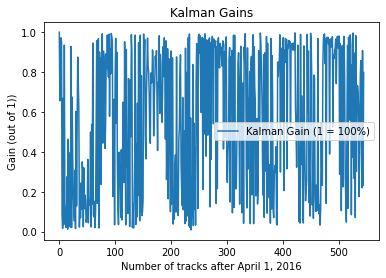

In [ ]:
# And finally to observe if the Kalman Gain was narrowing in on 0:
x = range(len(kalman_gains))
y = kalman_gains
plt.title("Kalman Gains")
plt.xlabel("Number of tracks after April 1, 2016") # A track varies in timing, but averages to every 3 days.
plt.ylabel("Gain (out of 1))")
plt.plot(x,y, label = 'Kalman Gain (1 = 100%)')
plt.legend()
plt.show()

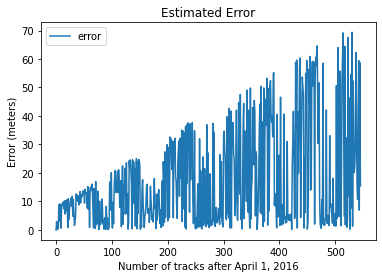

In [ ]:
# And finally to observe what the pattern of the errors is:
x = range(len(predicted_errors))
y = predicted_errors
plt.title("Estimated Error")
plt.xlabel("Number of tracks after April 1, 2016") # A track varies in timing, but averages to every 3 days.
plt.ylabel("Error (meters)")
plt.plot(x,y, label='error')
plt.legend()
plt.show()

### A Revelation!!!
##### The greater the measured error, the less the filter trusts the data. Naturally. 
##### In the two standard deviation dataset, a lot of the noise (that wasn't an incorrect measurement made near a shoreline) was artificially removed. This made the measured error amplitudes unnaturally low. Which meant the algorithm would trust the measurements more. 
##### Now, the KF is operating much better; ignoring the extreme changes in water level, which almost always coincide with larger measured error at that timestep. 
#### Note: We can tell that it isn't fully functional yet, because the Kalman Gains aren't narrowing in on '1'. The Filter just maintains confidence because throughout the data, some of the error amplitudes are relatively extreme. 

### Where to from here?
##### Two standard deviations seems to remove some useful data. But the raw data is artificially giving the KF too much confidence, as shoreline measurements need to be discounted. Perhaps three standard deviations is an easy to implement, healthy compromise? 